#Using Movie lens dataset for 100k ratings only and test it on the biases only model

##Exploring the dataset and creating data structure for users and movies

 Downloading the MovieLens dataset (100K ratings version)





In [2]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-12-25 13:16:48--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.29MB/s    in 0.3s    

2024-12-25 13:16:49 (3.29 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Importing required libraries for preprocessing the data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter

Exploring the dataset

In [6]:
all_ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')
all_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Calculate and display basic statistics about the dataset

In [9]:
num_users = len(all_ratings["userId"].unique())
num_movies = len(all_ratings["movieId"].unique())
num_ratings = len(all_ratings)
print("Number of users: ", num_users)
print("Number of movies: ", num_movies)
print("Number of ratings: ",num_ratings)

Number of users:  610
Number of movies:  9724
Number of ratings:  100836


unique mappings for user IDs and movie IDs

In [42]:
# Ids ==> indices
USER_TO_IDX = {userId: idx for idx, userId in enumerate(all_ratings["userId"].unique())}
MOVIE_TO_IDX = {movieId: idx for idx, movieId in enumerate(all_ratings["movieId"].unique())}

# indices ==> Ids
idx_to_user = list(USER_TO_IDX.keys())
idx_to_movie = list(MOVIE_TO_IDX.keys())

print("user_to_id mapping:", dict(list(USER_TO_IDX.items())[:5]))
print("movie_to_id mapping:", dict(list(MOVIE_TO_IDX.items())[:5]))

user_to_id mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
movie_to_id mapping: {1: 0, 3: 1, 6: 2, 47: 3, 50: 4}


* Create data structures for users and movies containing their respective movie/user IDs and ratings.
* users_data = [[(movieId, rating)...], [(movieId, rating) ...] ...]
* Same for movies_data except it contains userId

In [43]:
# Total numbers of users/movies
U = len(idx_to_user)
M = len(idx_to_movie)

users_data = [[] for _ in range(U)]
movies_data = [[] for _ in range(M)]

# iterate each row in the all_ratings DataFrame
for _, row in all_ratings.iterrows():
    user_id = int(row["userId"])
    movie_id = int(row["movieId"])
    rating = row["rating"]

    user_index = USER_TO_IDX[user_id]
    movie_index = MOVIE_TO_IDX[movie_id]

    # Append (movie_id, rating) to the user's data
    users_data[user_index].append((movie_id, rating))

    # Append (user_id, rating) to the movie's data
    movies_data[movie_index].append((user_id, rating))

print(f"Total users: {len(users_data)}, Total movies: {len(movies_data)}")
print("Sample users_data:", users_data[:2])  # first 2 users
print("Sample movies_data:", movies_data[:2]) # first 2 movies

Total users: 610, Total movies: 9724
Sample users_data: [[(1, 4.0), (3, 4.0), (6, 4.0), (47, 5.0), (50, 5.0), (70, 3.0), (101, 5.0), (110, 4.0), (151, 5.0), (157, 5.0), (163, 5.0), (216, 5.0), (223, 3.0), (231, 5.0), (235, 4.0), (260, 5.0), (296, 3.0), (316, 3.0), (333, 5.0), (349, 4.0), (356, 4.0), (362, 5.0), (367, 4.0), (423, 3.0), (441, 4.0), (457, 5.0), (480, 4.0), (500, 3.0), (527, 5.0), (543, 4.0), (552, 4.0), (553, 5.0), (590, 4.0), (592, 4.0), (593, 4.0), (596, 5.0), (608, 5.0), (648, 3.0), (661, 5.0), (673, 3.0), (733, 4.0), (736, 3.0), (780, 3.0), (804, 4.0), (919, 5.0), (923, 5.0), (940, 5.0), (943, 4.0), (954, 5.0), (1009, 3.0), (1023, 5.0), (1024, 5.0), (1025, 5.0), (1029, 5.0), (1030, 3.0), (1031, 5.0), (1032, 5.0), (1042, 4.0), (1049, 5.0), (1060, 4.0), (1073, 5.0), (1080, 5.0), (1089, 5.0), (1090, 4.0), (1092, 5.0), (1097, 5.0), (1127, 4.0), (1136, 5.0), (1196, 5.0), (1197, 5.0), (1198, 5.0), (1206, 5.0), (1208, 4.0), (1210, 5.0), (1213, 5.0), (1214, 4.0), (1219, 2.0),

* Power plot:
    * This plot shows the distribution of how many ratings each movie has received.
    * A small number of movies are extremely popular and receive a disproportionate number of ratings, while the majority are less popular.
    * We used plt.loglog(), because the logarithmic scale makes it easier to see the trend.

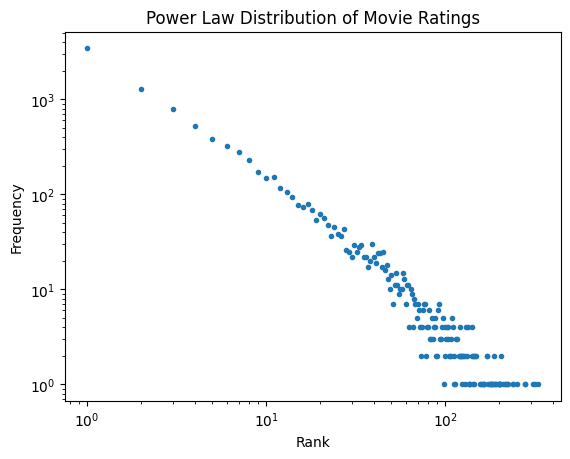

In [45]:
ratings_list = [len(movie_data) for movie_id, movie_data in enumerate(movies_data)]

ratings_list_dict = Counter(ratings_list)

plt.loglog(ratings_list_dict.keys(), ratings_list_dict.values(), ".")
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.title("Power Law Distribution of Movie Ratings")
plt.show()

##Building the Biases-only model

initialize user and movie biases with zeros

In [46]:
def init_biases(users_data, movies_data):
  user_biases = np.zeros(len(users_data))
  movie_biases= np.zeros(len(movies_data))
  return user_biases, movie_biases

*user/movie biases update functions*

* Equation for updating ith user bias:
$$b_u^{(i)} = \frac{\lambda \sum_{m \in M_u} (r_{um} - b_m)}{\lambda |M_u| + \gamma}$$
Where:
- $b_u^{(i)}$: Updated bias for user $u$.
- $r_{um}$: Rating given by user $u$ to movie $m$.
- $b_m$: Current bias for movie $m$.
- $M_u$: Set of movies rated by user $u$.
- $\lambda$: Regularization parameter to control overfitting.
- $\gamma$: Regularization constant.

* Equation for updating ith movie bias:
$$b_m^{(i)} = \frac{\lambda \sum_{u \in U_m} (r_{um} - b_u)}{\lambda |U_m| + \gamma}$$
Where:
- $b_m^{(i)}$: Updated bias for movie $m$.
- $r_{um}$: Rating given by user $u$ to movie $m$.
- $b_u$: Current bias for user $u$.
- $U_m$: Set of users who rated movie $m$.
- $\lambda$: Regularization parameter to control overfitting.
- $\gamma$: Regularization constant.

In [66]:
def update_user_biases(user_id, users_data, user_biases, movie_biases, lambda_, gamma):

    m = 0 # Number of movies rated by user
    error = 0
    for movie_rating in users_data[user_id]:
      if movie_rating: # make sure that the tuple isnt empty

        m +=1
        movie_id, rating = movie_rating
        movie_index = MOVIE_TO_IDX[movie_id]
        error+=(rating - movie_biases[movie_index])

    regularization_term = (lambda_*m)+ gamma
    user_biases[user_id] = lambda_*(error/regularization_term)

def update_movie_biases(movie_id, movies_data, user_biases, movie_biases, lambda_, gamma):

    u = 0 # Number of users rated this movie
    error = 0
    for user_rating in movies_data[movie_id]:
      if user_rating: # make sure that the tuple isnt empty

        u +=1
        user_id, rating = user_rating
        user_index = USER_TO_IDX[user_id]
        error+=(rating - user_biases[user_index])

    regularization_term = (lambda_*u)+ gamma
    movie_biases[movie_id] = lambda_*(error/regularization_term)


Negative Log Likelihood loss function \
$$L = \frac{\lambda}{2} \Sigma_{(u.m)\in D} (r_{um} - (b_u + b_m))^2 + \frac{\lambda}{2} (\Sigma_u b_u^2 + \Sigma_u b_m^2) \
$$

In [65]:
def calc_loss(users_data, user_biases, movie_biases, lambda_, gamma):
  total_loss = 0
  for user_id in range(len(users_data)):
    for movie_rating in users_data[user_id]:
      # Check for non-empty entries
      if movie_rating:
        movie_id , rating = movie_rating
        movie_index = MOVIE_TO_IDX[movie_id]
        predicted_rating = user_biases[user_id] + movie_biases[movie_index]
        total_loss += (rating - predicted_rating)**2

  # Regularization terms
  user_bias_sum = np.dot(user_biases, user_biases)
  movie_bias_sum= np.dot(movie_biases, movie_biases)
  total_loss = lambda_*total_loss + gamma*user_bias_sum + gamma*movie_bias_sum

  return 0.5*total_loss

Root Mean Squared Error \
$$ RMSE = \sqrt{\frac{1}{|D|}\Sigma_{(u.m)\in D} (r_{um} - (b_u + b_m))^2}$$

In [49]:
def calc_rmse(users_data, user_biases, movie_biases):
  squared_error = 0
  count = 0
  for user_id in range(len(users_data)):
    for movie_rating in users_data[user_id]:
      # Check for non-empty entries
      if movie_rating:
        movie_id , rating = movie_rating
        movie_index = MOVIE_TO_IDX[movie_id]

        predicted_rating = user_biases[user_id] +  movie_biases[movie_index]
        squared_error += (rating - predicted_rating)**2
        count+=1  # Increment count of valid ratings
  rmse =  np.sqrt(squared_error/count)
  return rmse



Splitting the dataset into train and test datasets, each for the movies and users data

In [51]:
def split(users_data, movies_data, test_ratio=0.2):
    U = len(users_data)
    M = len(movies_data)

    users_data_train = [[] for _ in range(U)]
    users_data_test = [[] for _ in range(U)]
    movies_data_train = [[] for _ in range(M)]
    movies_data_test = [[] for _ in range(M)]

    for user_id, user_data in enumerate(users_data):
        for movie_rating in user_data:
            if np.random.rand() > test_ratio:
                # Train set
                users_data_train[user_id].append(movie_rating)

                # placeholder for missing test entries
                users_data_test[user_id].append(())
            else:
                # Test set
                users_data_test[user_id].append(movie_rating)

                # placeholder for missing train entries
                users_data_train[user_id].append(()) # None or ()

    for movie_id, movie_row in enumerate(movies_data):
      for user_rating in movie_row:
        if np.random.rand()>test_ratio:
          movies_data_train[movie_id].append(user_rating)
          movies_data_test[movie_id].append(())
        else:
          movies_data_test[movie_id].append(user_rating)
          movies_data_train[movie_id].append(())

    return users_data_train, users_data_test, movies_data_train, movies_data_test


Training the model

In [52]:
def train_model(users_data, movies_data, iterations, lambda_=0.1, gamma=0.1):

      users_data_train, users_data_test, movies_data_train, movies_data_test = split(users_data, movies_data)

      losses_list, rmse_train_list, rmse_test_list  = [], [], []
      user_biases, movie_biases = init_biases(users_data_train, movies_data_train)

      for i in range(iterations):
        print(f"Iteraation: ({i+1}/{iterations})")
        # Update users biases
        for user_id in range(len(users_data_train)):
            update_user_biases(user_id ,users_data_train, user_biases, movie_biases, lambda_, gamma)
        # Update movies biases
        for movie_id in range(len(movies_data_train)):
            update_movie_biases(movie_id, movies_data_train, user_biases, movie_biases, lambda_, gamma)

        # Calculate loss and RMSE values
        loss = calc_loss(users_data_train, user_biases, movie_biases, lambda_, gamma)
        rmse_train = calc_rmse(users_data_train, user_biases, movie_biases)
        rmse_test = calc_rmse(users_data_test, user_biases, movie_biases)

        losses_list.append(loss)
        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)


        print(f"Loss: ==> {loss}, RMSE (Train):==> {rmse_train}, RMSE (Test):==> {rmse_test}")


      return losses_list, rmse_train_list, rmse_test_list, user_biases, movie_biases



Performing training with different values for the hypereparameters.

In [63]:
lambda_values = [0.01, 0.05, 0.1, 0.15, 0.2]
gamma_values = [0.001, 0.01, 0.1, 1]
losses_values = []
rmse_train_values = []
rmse_test_values = []

for lambda_ in lambda_values:
  for gamma in gamma_values:
        losses, rmse_train, rmse_test, user_biases, movie_biases = train_model(users_data, movies_data, 10, lambda_, gamma)
        losses_values.append(losses)
        rmse_train_values.append(rmse_train)
        rmse_test_values.append(rmse_test)


Iteraation: (1/10)
Loss: ==> 273.6958180229939, RMSE (Train):==> 0.814390657829983, RMSE (Test):==> 0.8302916896730081
Iteraation: (2/10)
Loss: ==> 263.344019340339, RMSE (Train):==> 0.7981651625386166, RMSE (Test):==> 0.8134484661796209
Iteraation: (3/10)
Loss: ==> 262.70900124688245, RMSE (Train):==> 0.7970820179405317, RMSE (Test):==> 0.8121283513558147
Iteraation: (4/10)
Loss: ==> 262.6481450170728, RMSE (Train):==> 0.7969761182782588, RMSE (Test):==> 0.8119436530105766
Iteraation: (5/10)
Loss: ==> 262.62725138330813, RMSE (Train):==> 0.7969577879657593, RMSE (Test):==> 0.811896342609903
Iteraation: (6/10)
Loss: ==> 262.60885502545335, RMSE (Train):==> 0.7969504387593158, RMSE (Test):==> 0.8118756336915783
Iteraation: (7/10)
Loss: ==> 262.59051000879515, RMSE (Train):==> 0.7969448792292423, RMSE (Test):==> 0.8118619410631751
Iteraation: (8/10)
Loss: ==> 262.5723754323833, RMSE (Train):==> 0.7969397366650041, RMSE (Test):==> 0.811850590399498
Iteraation: (9/10)
Loss: ==> 262.5546597

plot of the results

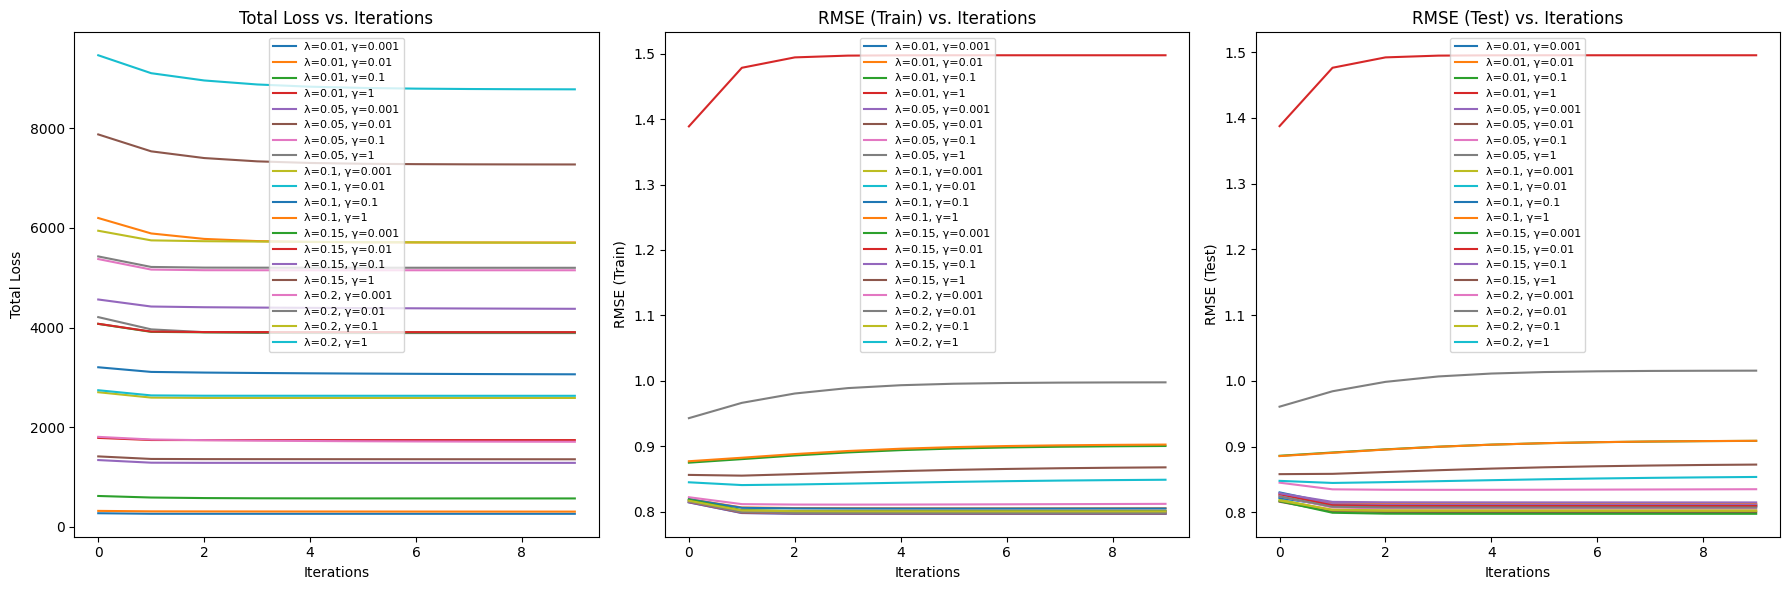

In [64]:
def plot_all_results(losses_values, rmse_train_values, rmse_test_values, lambda_values, gamma_values):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Total loss plot
    for i, losses in enumerate(losses_values):
        lambda_idx = i // len(gamma_values)
        gamma_idx = i % len(gamma_values)
        label = f"λ={lambda_values[lambda_idx]}, γ={gamma_values[gamma_idx]}"
        axes[0].plot(losses, label=label)
    axes[0].set_title("Total Loss vs. Iterations")
    axes[0].set_xlabel("Iterations")
    axes[0].set_ylabel("Total Loss")
    axes[0].legend(fontsize=8)

    # RMSE (Train) plot
    for i, rmse_train in enumerate(rmse_train_values):
        lambda_idx = i // len(gamma_values)
        gamma_idx = i % len(gamma_values)
        label = f"λ={lambda_values[lambda_idx]}, γ={gamma_values[gamma_idx]}"
        axes[1].plot(rmse_train, label=label)
    axes[1].set_title("RMSE (Train) vs. Iterations")
    axes[1].set_xlabel("Iterations")
    axes[1].set_ylabel("RMSE (Train)")
    axes[1].legend(fontsize=8)

    # RMSE (Test) plot
    for i, rmse_test in enumerate(rmse_test_values):
        lambda_idx = i // len(gamma_values)
        gamma_idx = i % len(gamma_values)
        label = f"λ={lambda_values[lambda_idx]}, γ={gamma_values[gamma_idx]}"
        axes[2].plot(rmse_test, label=label)
    axes[2].set_title("RMSE (Test) vs. Iterations")
    axes[2].set_xlabel("Iterations")
    axes[2].set_ylabel("RMSE (Test)")
    axes[2].legend(fontsize=8)

    plt.tight_layout()
    plt.show()

plot_all_results(losses_values, rmse_train_values, rmse_test_values, lambda_values, gamma_values)
